In [1]:
%load_ext autoreload
%autoreload 2
import anvil
import anvil.adaround

import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import copy
import torch.optim as optim
import os, pathlib

import matplotlib.pyplot as plt
import numpy as np

base_path = pathlib.Path("/home/mpuscian/Desktop/repozytoria/MINI_projects/anvil/models/")
model_path = base_path.joinpath("cifar_model.pth")
adaround_model_path = base_path.joinpath("adaround_model.pth")


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(512, 10)
model.load_state_dict(torch.load(model_path, map_location=device))

sample_input = torch.randn(1, 3, 32, 32)

# Loading datasets

In [2]:

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

full_train_dataset = datasets.CIFAR10(root=base_path.joinpath('data'), train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root=base_path.joinpath('data'), train=False, download=True, transform=transform_test)

train_size = int(0.9 * len(full_train_dataset))  # 45,000
val_size = len(full_train_dataset) - train_size  # 5,000
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# 4. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=6)
val_dataset.dataset.transform = transform_test
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=6)

In [3]:
images_list = []
for batch in val_loader:
    images = batch[0] if isinstance(batch, (list, tuple)) else batch  # handles (images, labels) or just images
    images_list.append(images)
    total = sum(img.shape[0] for img in images_list)
    if total >= 1000:
        break

images_1 = torch.cat(images_list, dim=0)[:50]
images_1 = images_1.to(device)

In [4]:
model = model.to(device)

In [17]:
for i in list(model.named_modules()):
    if i[0] != '':
        print(i[0], type(i[1]))

conv1 <class 'torch.nn.modules.conv.Conv2d'>
bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
relu <class 'torch.nn.modules.activation.ReLU'>
maxpool <class 'torch.nn.modules.linear.Identity'>
layer1 <class 'torch.nn.modules.container.Sequential'>
layer1.0 <class 'torchvision.models.resnet.BasicBlock'>
layer1.0.conv1 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.0.relu <class 'torch.nn.modules.activation.ReLU'>
layer1.0.conv2 <class 'torch.nn.modules.conv.Conv2d'>
layer1.0.bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.1 <class 'torchvision.models.resnet.BasicBlock'>
layer1.1.conv1 <class 'torch.nn.modules.conv.Conv2d'>
layer1.1.bn1 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer1.1.relu <class 'torch.nn.modules.activation.ReLU'>
layer1.1.conv2 <class 'torch.nn.modules.conv.Conv2d'>
layer1.1.bn2 <class 'torch.nn.modules.batchnorm.BatchNorm2d'>
layer2 <class 'torch.nn.modules.container.Sequential'>
lay

In [75]:
adaround_wrapper = anvil.adaround.AdaRoundModelWrapper(model, images_1)
adaround_statistics, quantizized_weights, quantizized_model = adaround_wrapper.apply_adaround_to_layers(reg_param=2, bitwidth=4, per_channel=False, num_iterations=3500, beta_range=(20, 2), optimizer_lr=3e-2, use_quantiles=True, lower_quantile=0.00005, upper_quantile=0.99995)

Quantizizing conv and lin
 params:  4 2 False 3500 (20, 2) 0.03


Processing modules - Current: conv1: : 0it [00:00, ?it/s]

min: -0.25015148520469666, max: 0.2506757080554962


Processing modules - Current: layer1.0.conv1: : 2it [00:03,  1.68s/it]

min: -0.2142745852470398, max: 0.1660638004541397


Processing modules - Current: layer1.0.conv2: : 8it [00:08,  1.07s/it]

min: -0.18321998417377472, max: 0.17276158928871155


Processing modules - Current: layer1.1.conv1: : 11it [00:13,  1.22s/it]

min: -0.19302745163440704, max: 0.1632901430130005


Processing modules - Current: layer1.1.conv2: : 14it [00:18,  1.43s/it]

min: -0.1803359091281891, max: 0.16611817479133606


Processing modules - Current: layer2.0.conv1: : 17it [00:23,  1.44s/it]

min: -0.15494774281978607, max: 0.18094487488269806


Processing modules - Current: layer2.0.conv2: : 21it [00:27,  1.25s/it]

min: -0.1678522676229477, max: 0.15561945736408234


Processing modules - Current: layer2.0.downsample.0: : 24it [00:30,  1.23s/it]

min: -0.23204542696475983, max: 0.33533433079719543


Processing modules - Current: layer2.1.conv1: : 27it [00:33,  1.11s/it]       

min: -0.12702588737010956, max: 0.13170595467090607


Processing modules - Current: layer2.1.conv2: : 30it [00:37,  1.19s/it]

min: -0.12647868692874908, max: 0.13044346868991852


Processing modules - Current: layer3.0.conv1: : 33it [00:40,  1.19s/it]

min: -0.12902294099330902, max: 0.14738915860652924


Processing modules - Current: layer3.0.conv2: : 37it [00:44,  1.06s/it]

min: -0.12423983216285706, max: 0.13682061433792114


Processing modules - Current: layer3.0.downsample.0: : 40it [00:47,  1.13s/it]

min: -0.19384238123893738, max: 0.22219420969486237


Processing modules - Current: layer3.1.conv1: : 43it [00:50,  1.06s/it]       

min: -0.11791452765464783, max: 0.13194242119789124


Processing modules - Current: layer3.1.conv2: : 46it [00:54,  1.16s/it]

min: -0.11708496510982513, max: 0.12192979454994202


Processing modules - Current: layer4.0.conv1: : 49it [00:58,  1.20s/it]

min: -0.109967902302742, max: 0.12523911893367767


Processing modules - Current: layer4.0.conv2: : 53it [01:02,  1.10s/it]

min: -0.0601407065987587, max: 0.07794895768165588


Processing modules - Current: layer4.0.downsample.0: : 56it [01:08,  1.39s/it]

min: -0.09025473892688751, max: 0.12519408762454987


Processing modules - Current: layer4.1.conv1: : 59it [01:11,  1.23s/it]       

min: -0.05666574835777283, max: 0.08149871230125427


Processing modules - Current: layer4.1.conv2: : 62it [01:18,  1.52s/it]

min: -0.04504752904176712, max: 0.05984118953347206


Processing modules - Current: fc: : 65it [01:24,  1.70s/it]            

min: -0.2655316889286041, max: 0.17170578241348267


Processing modules - Current: fc: : 68it [01:26,  1.28s/it]


In [76]:
y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')
print(f"accuracy after quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score after quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy after quantization: 0.8128
f1 score after quantization: 0.8145


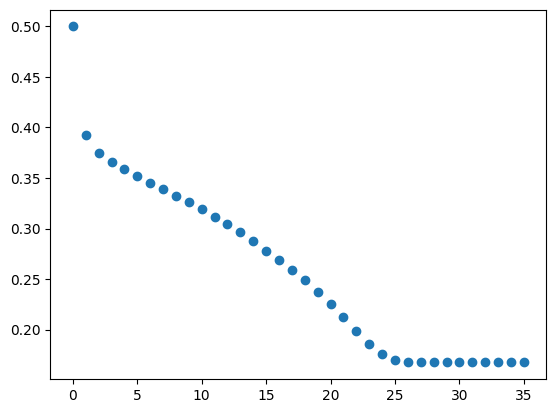

In [6]:
means = []
for h_alpha in adaround_statistics['layer4.0.conv1']['h_alphas']:
    means.append(h_alpha.to("cpu").mean())
plt.scatter([i for i in range(len(means))], means)

In [7]:

layer41conv2 = None
for name, module in quantizized_model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        print(f"Unique weights: {torch.unique(module.weight).shape}")
        if name == "layer4.1.conv2":
            layer41conv2 = module.weight.detach()

baselayer41conv2 = None
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv2d, nn.Linear)):
        if name == "layer4.1.conv2":
            baselayer41conv2 = module.weight.detach()

Unique weights: torch.Size([15])
Unique weights: torch.Size([16])
Unique weights: torch.Size([15])
Unique weights: torch.Size([15])
Unique weights: torch.Size([15])
Unique weights: torch.Size([16])
Unique weights: torch.Size([16])
Unique weights: torch.Size([15])
Unique weights: torch.Size([15])
Unique weights: torch.Size([16])
Unique weights: torch.Size([16])
Unique weights: torch.Size([16])
Unique weights: torch.Size([16])
Unique weights: torch.Size([16])
Unique weights: torch.Size([16])
Unique weights: torch.Size([16])
Unique weights: torch.Size([16])
Unique weights: torch.Size([15])
Unique weights: torch.Size([16])
Unique weights: torch.Size([16])
Unique weights: torch.Size([16])


In [8]:
sortedd = torch.unique(layer41conv2).msort()
for i, val in enumerate(sortedd):
    if i > 0:
        print(sortedd[i] - sortedd[i-1])

tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')
tensor(0.0101, device='cuda:0')


In [9]:
weights = quantizized_model.layer4[1].conv2.weight

In [10]:
print(f"Unique weights: {torch.unique(weights).shape}")

Unique weights: torch.Size([16])


In [11]:
torch.unique(weights)

tensor([-0.0710, -0.0609, -0.0507, -0.0406, -0.0304, -0.0203, -0.0101,  0.0000,
         0.0101,  0.0203,  0.0304,  0.0406,  0.0507,  0.0609,  0.0710,  0.0812],
       device='cuda:0', grad_fn=<Unique2Backward0>)

In [12]:
torch.cat(adaround_statistics['conv1']['losses'])

tensor([3.4561e+03, 3.4066e+03, 3.1174e+03, 2.7809e+03, 2.4991e+03, 2.2283e+03,
        1.9414e+03, 1.6623e+03, 1.4221e+03, 1.1498e+03, 9.0831e+02, 7.0284e+02,
        5.3202e+02, 3.4276e+02, 2.3400e+02, 1.1647e+02, 5.9689e+01, 3.1200e+01,
        1.4007e+01, 1.2007e+01, 8.0074e+00, 7.4756e-03, 7.4756e-03, 7.4756e-03,
        7.4756e-03, 7.4756e-03, 7.4756e-03, 7.4756e-03, 7.4756e-03, 7.4756e-03,
        7.4756e-03, 7.4756e-03, 7.4756e-03, 7.4756e-03, 7.4756e-03])

In [13]:
i = 0

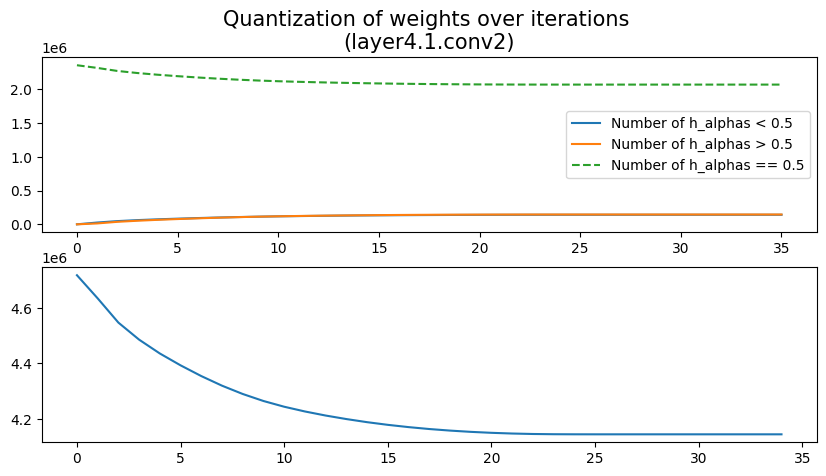

last loss: 4144128.0
last nubmer of h_alphas other than 0 or 1: 2072064


In [33]:
layer_to_plot = list(adaround_statistics.keys())[i]
#layer_to_plot = 'layer3.0.conv2'
i+=1

raveled_h_alphas = []
zeros_count_arr = []
ones_count_arr = []
other_count_arr = []

for h_alphas in adaround_statistics[layer_to_plot]['h_alphas']:
    raveled = torch.ravel(h_alphas.to("cpu")).numpy()
    zeros_count = np.where(raveled == 0)[0].shape[0]
    ones_count = np.where(raveled  == 1)[0].shape[0]
    other_count = raveled.shape[0] - zeros_count - ones_count

    zeros_count_arr.append(zeros_count)
    ones_count_arr.append(ones_count)
    other_count_arr.append(other_count)

fig, axes = plt.subplots(2,1, figsize=(10, 5))
axes[0].plot(zeros_count_arr, label='Number of h_alphas < 0.5')
axes[0].plot(ones_count_arr, label='Number of h_alphas > 0.5')
axes[0].plot(other_count_arr, "--", label='Number of h_alphas == 0.5')

axes[0].set_title(f"Quantization of weights over iterations \n({layer_to_plot})", fontsize=15)
axes[0].legend()

losses_cpu = torch.cat(adaround_statistics[layer_to_plot]['losses']).to("cpu")
axes[1].plot(losses_cpu)
plt.show()
print(f"last loss: {losses_cpu[-1]}")
print(f"last nubmer of h_alphas other than 0 or 1: {other_count_arr[-1]}")

In [34]:
adaround_statistics[layer_to_plot]['losses']

[tensor([4718592.]),
 tensor([4635092.]),
 tensor([4547510.5000]),
 tensor([4485969.]),
 tensor([4436031.5000]),
 tensor([4393219.]),
 tensor([4354459.]),
 tensor([4319774.]),
 tensor([4289786.5000]),
 tensor([4264469.]),
 tensor([4243784.5000]),
 tensor([4226665.]),
 tensor([4211971.]),
 tensor([4199259.5000]),
 tensor([4188021.7500]),
 tensor([4178388.]),
 tensor([4170190.]),
 tensor([4163264.]),
 tensor([4157626.5000]),
 tensor([4153064.]),
 tensor([4149568.5000]),
 tensor([4147006.5000]),
 tensor([4145326.2500]),
 tensor([4144498.2500]),
 tensor([4144199.7500]),
 tensor([4144132.]),
 tensor([4144128.]),
 tensor([4144128.]),
 tensor([4144128.]),
 tensor([4144128.]),
 tensor([4144128.]),
 tensor([4144128.]),
 tensor([4144128.]),
 tensor([4144128.]),
 tensor([4144128.])]

In [35]:
torch.unique(dict(quantizized_model.named_modules())[layer_to_plot].weight)

tensor([-0.0710, -0.0609, -0.0507, -0.0406, -0.0304, -0.0203, -0.0101,  0.0000,
         0.0101,  0.0203,  0.0304,  0.0406,  0.0507,  0.0609,  0.0710,  0.0812],
       device='cuda:0', grad_fn=<Unique2Backward0>)

In [36]:
i = 0

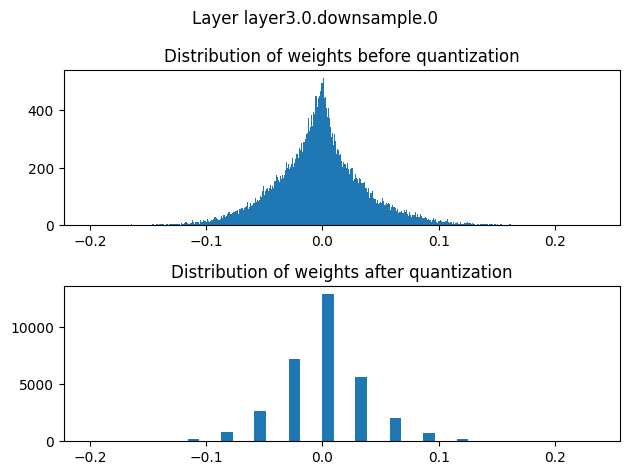

Unique weights before 32762
Variance of weights before: 0.001620332128368318
Unique weights after 16
Unique h_alphas at the end: tensor([0., 1.], device='cuda:0')
Number of h_alphas 1/2: 0


In [49]:
layer_to_plot = list(adaround_statistics.keys())[i]
i+=1
module_to_plot_before = dict(model.named_modules())[layer_to_plot]
_weights_before = torch.ravel(module_to_plot_before.weight.to("cpu").detach())

module_to_plot_after = dict(quantizized_model.named_modules())[layer_to_plot]
_weights_after = torch.ravel(module_to_plot_after.weight.to("cpu").detach())

fig, axes = plt.subplots(2,1)
axes[0].hist(_weights_before, bins=500)
axes[1].hist(_weights_after, bins=500, width=0.01)
axes[1].set_xlim(axes[0].get_xlim())

axes[0].set_title("Distribution of weights before quantization")
axes[1].set_title("Distribution of weights after quantization")
fig.suptitle(f"Layer {layer_to_plot}")
plt.tight_layout()
plt.show()


print("Unique weights before", torch.unique(_weights_before).shape[0])
print(f"Variance of weights before: {torch.var(_weights_before)}")
print("Unique weights after", torch.unique(_weights_after).shape[0])
print(f"Unique h_alphas at the end: {torch.unique(adaround_statistics[layer_to_plot]['h_alphas'][-1])}")
end_h_alphas = torch.ravel(adaround_statistics[layer_to_plot]['h_alphas'][-1]).cpu().numpy()
print(f"Number of h_alphas 1/2: {end_h_alphas.shape[0] - np.where(end_h_alphas < 1/2)[0].shape[0] - np.where(end_h_alphas > 1/2)[0].shape[0]}")

In [50]:
np.histogram(dict(model.named_modules())[layer_to_plot].cpu().weight.detach(), bins=10)[0]

array([   28,   166,  1293,  6132, 16522,  6557,  1671,   344,    44,
          11])

In [51]:
np.histogram(dict(quantizized_model.named_modules())[layer_to_plot].cpu().weight.detach(), bins=10)

(array([   20,    36,  1039,  2700, 20185,  5632,  2846,   229,    74,
            7]),
 array([-0.20305309, -0.15954171, -0.11603034, -0.07251896, -0.02900758,
         0.01450379,  0.05801517,  0.10152654,  0.14503792,  0.1885493 ,
         0.23206067], dtype=float32))

In [53]:
torch.quantile(torch.ravel(dict(model.named_modules())[layer_to_plot].weight),0.01)

tensor(-0.1035, grad_fn=<SqueezeBackward4>)

In [ ]:
Processing modules - Current: layer4.0.conv2: : 53it [00:35,  1.63it/s]
min: -0.0001544490660307929, max: 7.715923129580915e-05

In [54]:
np.histogram(_weights_before, bins=100)

(array([   2,    0,    2,    3,    1,    6,    4,    3,    5,    2,    1,
           1,   13,   13,   18,   15,   21,   24,   22,   38,   53,   53,
          77,   78,  102,  114,  152,  186,  222,  256,  299,  345,  391,
         441,  583,  645,  702,  825,  869, 1032, 1101, 1262, 1423, 1684,
        1962, 2264, 2310, 1809, 1460, 1247, 1051,  986,  856,  782,  707,
         568,  474,  397,  395,  341,  306,  237,  235,  178,  187,  154,
         125,   93,   85,   71,   78,   50,   44,   33,   41,   34,   16,
          16,   18,   14,   11,   10,    7,    9,    1,    1,    1,    1,
           2,    1,    5,    0,    0,    0,    1,    1,    2,    1,    0,
           1]),
 array([-0.20087695, -0.19652581, -0.19217467, -0.18782353, -0.1834724 ,
        -0.17912127, -0.17477013, -0.170419  , -0.16606785, -0.16171671,
        -0.15736558, -0.15301444, -0.1486633 , -0.14431216, -0.13996103,
        -0.1356099 , -0.13125876, -0.12690762, -0.12255648, -0.11820534,
        -0.1138542 , -0.10

In [55]:
def evaluate_model(model, dataloader, device):
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.append(predicted.cpu())
            all_labels.append(labels.cpu())
    
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    
    return all_labels, all_preds

In [56]:
from sklearn import metrics

In [57]:
y_true, y_pred = evaluate_model(model, test_loader, 'cuda:0')
print(f"accuracy before quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score before quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy before quantization: 0.8258
f1 score before quantization: 0.8268


In [58]:
y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')
print(f"accuracy after quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score after quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy after quantization: 0.8105
f1 score after quantization: 0.8122


**one channel quantization, 2 bits, 1 calibration sample(RANDOM)** <br>
acc : 0.2918

# Grid search

In [ ]:
lr : [0.05, 0.01, 0.005, 0.001]
reg_param: [0.1, 0.07, 0.05, 0.01, 0.005]
num_iteration: [500, 1000, 2000, 3000, 4000]
beta_range: [(10, 2), (20, 2), (40,2), (20,1), (20,0.5)]

In [100]:
params = {
    'bitwidth' : 8,
    'reg_param' : 0.05,
    'num_iterations' : 2000,
    'per_channel' : False,
    'beta_range' : (20, 2),
    'optimizer_lr' : 0.005

}

In [94]:
adaround_wrapper = anvil.adaround.AdaRoundModelWrapper(model, images_1)
adaround_statistics, quantizized_weights, quantizized_model = adaround_wrapper.apply_adaround_to_layers(**params)

Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.001


Processing modules - Current: fc: : 68it [00:44,  1.52it/s]                   


In [95]:
y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')

parameter_search[int(np.max(list(parameter_search.keys())) + 1)] = {
    'params' : params,
    'accuracry' : metrics.accuracy_score(y_true, y_pred),
    'f1_Score' : metrics.f1_score(y_true, y_pred, average='macro'),
    'y_pred' : y_pred,
    'y_true' : y_true
}

In [96]:
parameter_search

{0: {'params': {'bitwidth': 8,
   'reg_param': 0.01,
   'num_iterations': 1000,
   'per_channel': False,
   'beta_range': (20, 2),
   'optimizer_lr': 0.01},
  'accuracry': 0.8224,
  'f1_Score': 0.8235657650517343,
  'y_pred': tensor([3, 8, 1,  ..., 5, 1, 7]),
  'y_true': tensor([3, 8, 8,  ..., 5, 1, 7])},
 1: {'params': {'bitwidth': 8,
   'reg_param': 0.05,
   'num_iterations': 1000,
   'per_channel': False,
   'beta_range': (20, 2),
   'optimizer_lr': 0.01},
  'accuracry': 0.8235,
  'f1_Score': 0.8245692559755922,
  'y_pred': tensor([3, 8, 1,  ..., 5, 1, 7]),
  'y_true': tensor([3, 8, 8,  ..., 5, 1, 7])},
 2: {'params': {'bitwidth': 8,
   'reg_param': 0.1,
   'num_iterations': 1000,
   'per_channel': False,
   'beta_range': (20, 2),
   'optimizer_lr': 0.01},
  'accuracry': 0.8231,
  'f1_Score': 0.8242453575956576,
  'y_pred': tensor([3, 8, 1,  ..., 5, 1, 7]),
  'y_true': tensor([3, 8, 8,  ..., 5, 1, 7])},
 3: {'params': {'bitwidth': 8,
   'reg_param': 0.05,
   'num_iterations': 500,
 

# Mean acc

In [127]:
accuracies = []
for i in range(5):
    indices = torch.randperm(images.size(0))[:100]
    sample_images = torch.cat(images_list, dim=0)[indices]
    
    adaround_wrapper = anvil.adaround.AdaRoundModelWrapper(model, sample_images)
    adaround_statistics, quantizized_weights, quantizized_model = adaround_wrapper.apply_adaround_to_layers(**params)

    y_true, y_pred = evaluate_model(quantizized_model, test_loader, 'cuda:0')
    accuracies.append(metrics.accuracy_score(y_true, y_pred))

Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.005


Processing modules - Current: fc: : 68it [01:09,  1.02s/it]                   


Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.005


Processing modules - Current: fc: : 68it [01:09,  1.02s/it]                   


Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.005


Processing modules - Current: fc: : 68it [01:09,  1.02s/it]                   


Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.005


Processing modules - Current: fc: : 68it [01:09,  1.02s/it]                   


Quantizizing conv and lin
 params:  8 0.05 False 2000 (20, 2) 0.005


Processing modules - Current: fc: : 68it [01:09,  1.02s/it]                   


In [139]:
y_true, y_pred = evaluate_model(model, test_loader, 'cuda:0')
print(f"accuracy before quantization: {metrics.accuracy_score(y_true, y_pred)}")
print(f"f1 score before quantization: {metrics.f1_score(y_true, y_pred, average='weighted'):.4f}")

accuracy before quantization: 0.8258
f1 score before quantization: 0.8268


In [138]:
print(f"Adaround: {np.mean(accuracies)} +- {np.std(accuracies):.4f}")

Adaround: 0.82568 +- 0.0009
